https://blog.esciencecenter.nl/build-your-own-mass-spectrometry-analysis-pipeline-in-python-using-matchms-part-i-d96c718c68ee

# 1. Import MS/MS data

In [1]:
import os
from matchms.importing import load_from_mgf
import numpy as np
from matplotlib import pyplot as plt
from matchms.exporting import save_as_json

In [2]:
path_data = ""  # enter path to downloaded mgf file
file_mgf = os.path.join(path_data, 
                        "GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf")
spectrums = list(load_from_mgf(file_mgf))

In [3]:
inchikeys = [s.get("inchikey") for s in spectrums]
found_inchikeys = np.sum([1 for x in inchikeys if x is not None])
print(f"Found {int(found_inchikeys)} inchikeys in metadata")

Found 0 inchikeys in metadata


Text(0, 0.5, 'Number of spectra')

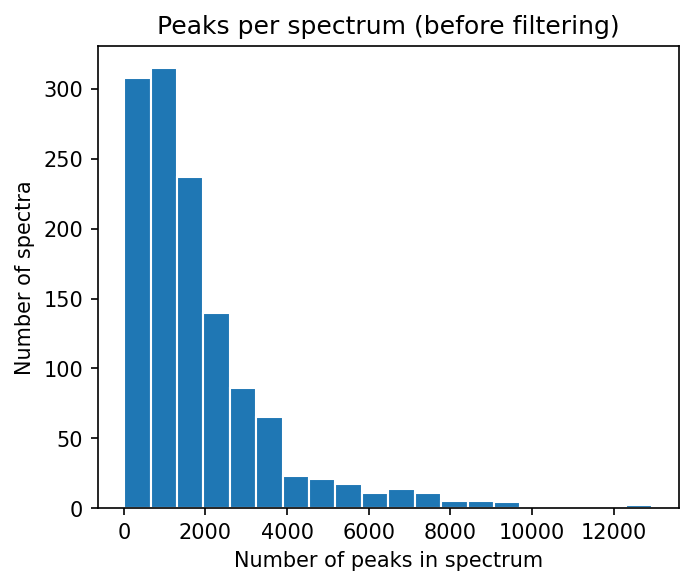

In [4]:
numbers_of_peaks = [len(s.peaks.mz) for s in spectrums]

plt.figure(figsize=(5,4), dpi=150)
plt.hist(numbers_of_peaks, 20, edgecolor="white")
plt.title("Peaks per spectrum (before filtering)")
plt.xlabel("Number of peaks in spectrum")
plt.ylabel("Number of spectra")

In [5]:
file_export_json = os.path.join(path_data, "GNPS-NIH- NATURALPRODUCTSLIBRARY_processed.json")
save_as_json(spectrums, file_export_json)

dict_keys(['spectra'])


A alternative that is much faster for reading/writing is to use pickle. Should data handling become an issue (e.g. many thousands spectrums), than this can be a way out.

# 2. Build a data processing pipeline

In [6]:
import matchms.filtering as ms_filters

In [7]:
def metadata_processing(spectrum):
    spectrum = ms_filters.default_filters(spectrum)
    spectrum = ms_filters.repair_inchi_inchikey_smiles(spectrum)
    spectrum = ms_filters.derive_inchi_from_smiles(spectrum)
    spectrum = ms_filters.derive_smiles_from_inchi(spectrum)
    spectrum = ms_filters.derive_inchikey_from_inchi(spectrum)
    spectrum = ms_filters.harmonize_undefined_smiles(spectrum)
    spectrum = ms_filters.harmonize_undefined_inchi(spectrum)
    spectrum = ms_filters.harmonize_undefined_inchikey(spectrum)
    spectrum = ms_filters.add_precursor_mz(spectrum)
    return spectrum

In [8]:
def peak_processing(spectrum):
    spectrum = ms_filters.default_filters(spectrum)
    spectrum = ms_filters.normalize_intensities(spectrum)
    spectrum = ms_filters.select_by_intensity(spectrum, intensity_from=0.01)
    spectrum = ms_filters.select_by_mz(spectrum, mz_from=10, mz_to=1000)
    return spectrum

In [9]:
spectrums = [metadata_processing(s) for s in spectrums]
spectrums = [peak_processing(s) for s in spectrums]

In [10]:
inchikeys = [s.get("inchikey") for s in spectrums]
inchikeys[:10]

['XTJNPXYDTGJZSA-PKOBYXMFSA-N',
 'VOYWJNWCKFCMPN-FHERZECASA-N',
 'IRZVHDLBAYNPCT-UHFFFAOYSA-N',
 'OPWCHZIQXUKNMP-RGEXLXHISA-N',
 'GTBYYVAKXYVRHX-BVSLBCMMSA-N',
 'UVZWLAGDMMCHPD-UHFFFAOYSA-N',
 'XKWILXCQJFNUJH-DEOSSOPVSA-N',
 'JDZNIWUNOASRIK-UHFFFAOYSA-N',
 'RCAVVTTVAJETSK-VXKWHMMOSA-N',
 'KQAZJQXFNDOORW-CABCVRRESA-N']

# 3. Compute spectra similarities : Cosine score

In [11]:
from matchms import calculate_scores
from matchms.similarity import CosineGreedy

In [12]:
similarity_measure = CosineGreedy(tolerance=0.005)

In [13]:
scores = calculate_scores(spectrums, spectrums, similarity_measure, is_symmetric=True)

In [14]:
scores.score_names

('CosineGreedy_score', 'CosineGreedy_matches')

In [15]:
scores_array = scores.scores.to_array()
scores_array[:5, :5]["CosineGreedy_score"]

array([[1.00000000e+00, 6.41050958e-03, 1.70386100e-04, 8.59172648e-04,
        2.35757313e-03],
       [6.41050958e-03, 1.00000000e+00, 1.37105333e-02, 9.45693252e-01,
        9.17922823e-05],
       [1.70386100e-04, 1.37105333e-02, 1.00000000e+00, 1.53604286e-02,
        0.00000000e+00],
       [8.59172648e-04, 9.45693252e-01, 1.53604286e-02, 1.00000000e+00,
        0.00000000e+00],
       [2.35757313e-03, 9.17922823e-05, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00]])

In [16]:
scores_array = scores.scores.to_array()
scores_array[:5, :5]["CosineGreedy_matches"]

array([[40,  2,  1,  4,  1],
       [ 2, 75,  2,  5,  1],
       [ 1,  2, 37,  4,  0],
       [ 4,  5,  4, 66,  0],
       [ 1,  1,  0,  0, 43]])

In [17]:
best_matches = scores.scores_by_query(spectrums[5], name="CosineGreedy_score", sort=True)[:10]
print([x[1] for x in best_matches])

[(1., 30), (0.99711049, 2), (0.99534901, 2), (0.99214557, 2), (0.98748381, 2), (0.98461111, 3), (0.98401833, 2), (0.97598497, 2), (0.9757458, 2), (0.97547771, 2)]


In [31]:
tutorial_smiles = [x[0].get("smiles") for x in best_matches]
tutorial_smiles

['OC(COC(=O)c1ccccc1)C(O)C(O)COC(=O)c2ccccc2',
 'Cc1cc(=O)oc2cc(OC(=O)c3ccccc3)ccc12',
 'O=C(Nc1ccccc1OC(=O)c2ccccc2)c3ccccc3',
 'COc1cc(CC=C)ccc1OC(=O)c2ccccc2',
 'O=C(OCC1OC(C(OC(=O)c2ccccc2)C1OC(=O)c3ccccc3)n4ncc(=O)[nH]c4=O)c5ccccc5',
 'O=C(Oc1cccc2ccccc12)c3ccccc3',
 'O=C(N1[C@@H](C#N)C2OC2c3ccccc13)c4ccccc4',
 'COC(=O)CNC(=O)c1ccccc1',
 'COc1c2OCOc2cc(CCN(C)C(=O)c3ccccc3)c1C=C4C(=O)NC(=O)NC4=O',
 'COc1c2OCOc2cc(CCN(C)C(=O)c3ccccc3)c1/C=C\\4/C(=O)NC(=O)N(C)C4=O']

d:\Programmierung\anaconda3\envs\matchms\Lib\site-packages\rdkit\Chem\Draw\__init__.py


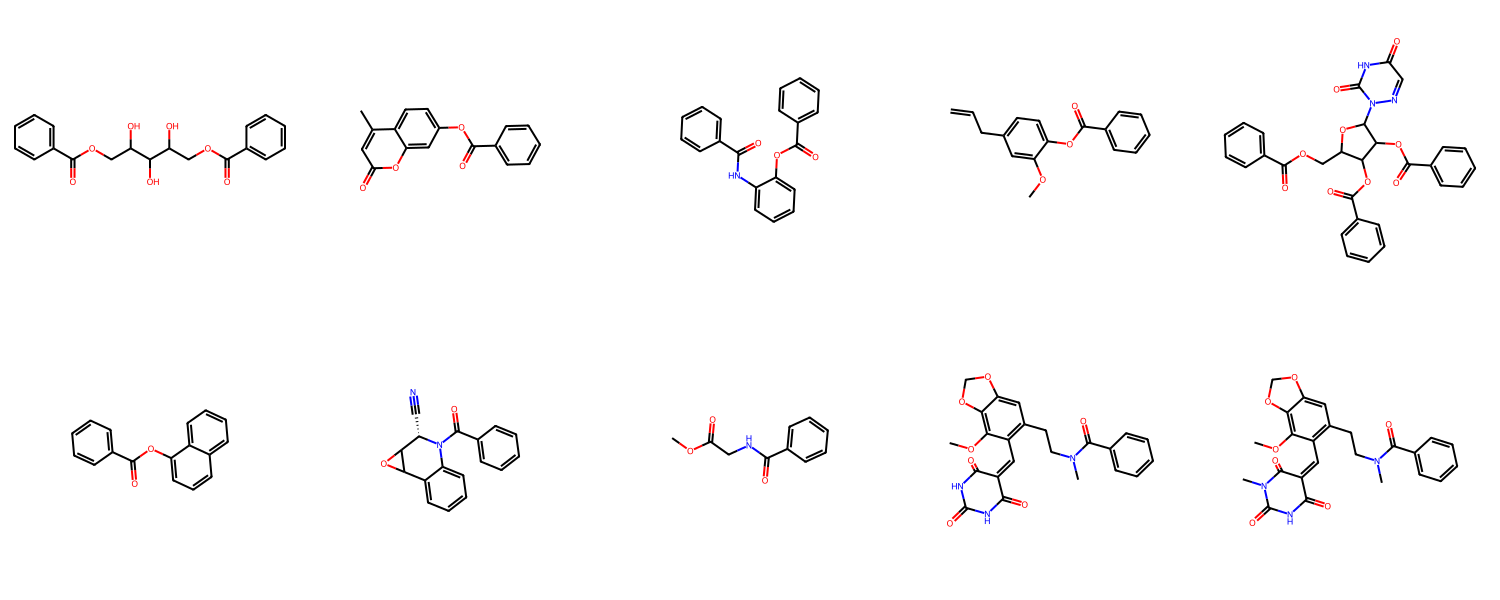

In [19]:
from rdkit import Chem
from rdkit.Chem import Draw

print(Draw.__file__)

mols = []
for i, smiles in enumerate([x[0].get("smiles") for x in    best_matches]):
    mols.append(Chem.MolFromSmiles(smiles))

Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(300,300))

# Similarity Maps

In [20]:
from rdkit.Chem.Draw import SimilarityMaps

## RDK SimilarityMap

refMol:
probeMol:
fpFunction:
<function GetRDKFingerprint at 0x00000210877E82C0>
metric:
weights type:
<class 'list'>
weights:
[0.0015151515151514694, 0.00040650406504061376, -0.013636363636363669, 0.003543307086614156, -0.09339622641509437, -0.1153465346534654, 0.18516483516483515, 0.06900826446280989, 0.26919191919191915, 0.23990825688073392, 0.1764462809917355, 0.1115384615384615, 0.1764462809917355, 0.23990825688073392]
refMol:
probeMol:
fpFunction:
<function GetRDKFingerprint at 0x00000210877E82C0>
metric:
weights type:
<class 'list'>
weights:
[0.07727272727272727, 0.2181318681318681, -0.09210526315789475, -0.025000000000000022, 0.015158371040723984, 0.04547325102880656, 0.05967741935483867, 0.03695652173913039, 0.05967741935483867, 0.0675572519083969, 0.06653543307086612, 0.0383116883116883, 0.0071428571428571175, 0.2695979899497487, 0.23990825688073392, 0.18471074380165287, 0.1115384615384615, 0.18471074380165287, 0.23990825688073392]


(<Figure size 250x250 with 1 Axes>, 0.2695979899497487)

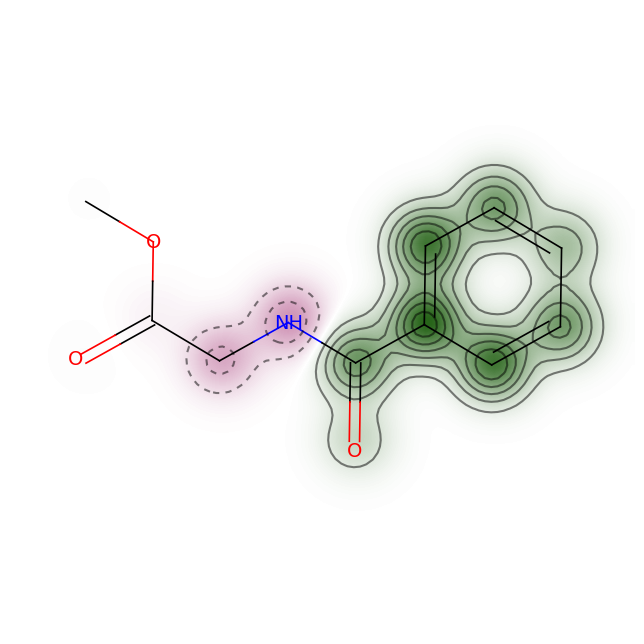

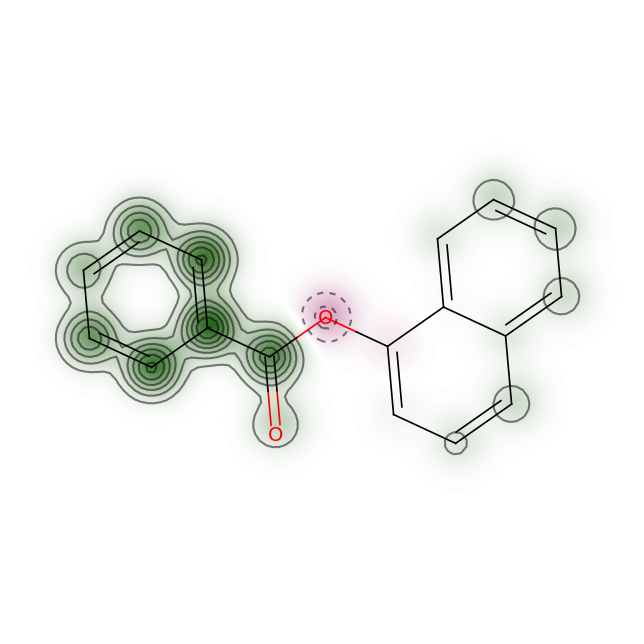

In [21]:
SimilarityMaps.GetSimilarityMapForFingerprint(mols[5], mols[7], SimilarityMaps.GetRDKFingerprint)
SimilarityMaps.GetSimilarityMapForFingerprint(mols[7], mols[5], SimilarityMaps.GetRDKFingerprint)


## Morgan SimilarityMap

refMol:
probeMol:
fpFunction:
<function GetMorganFingerprint at 0x00000210877E8CC0>
metric:
weights type:
<class 'list'>
weights:
[-0.047169811320754707, -0.025430680885972112, -0.0017152658662092368, 0.02729827378562827, -0.09262435677530012, -0.09262435677530012, 0.08073716542343135, 0.02729827378562827, 0.13464837049742712, 0.22555746140651803, 0.191960623461854, 0.1611635220125786, 0.191960623461854, 0.22555746140651803]
refMol:
probeMol:
fpFunction:
<function GetMorganFingerprint at 0x00000210877E8CC0>
metric:
weights type:
<class 'list'>
weights:
[0.02729827378562827, 0.08073716542343135, -0.05879771829749891, -0.047169811320754707, 0.034225537516454574, 0.05283018867924527, 0.04373927958833618, 0.024258760107816746, 0.09727463312368972, 0.10500410172272356, 0.10500410172272356, 0.08919382504288165, 0.0028301886792452824, 0.13464837049742712, 0.22555746140651803, 0.191960623461854, 0.1611635220125786, 0.191960623461854, 0.22555746140651803]


(<Figure size 250x250 with 1 Axes>, 0.22555746140651803)

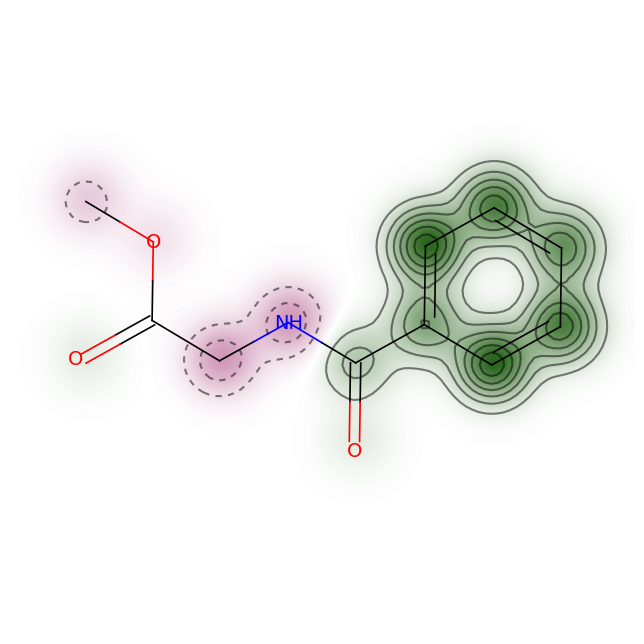

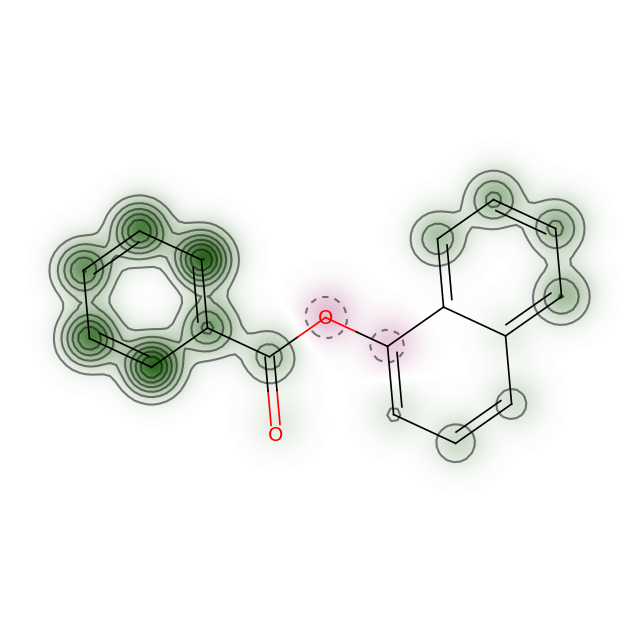

In [22]:
SimilarityMaps.GetSimilarityMapForFingerprint(mols[5], mols[7], SimilarityMaps.GetMorganFingerprint)
SimilarityMaps.GetSimilarityMapForFingerprint(mols[7], mols[5], SimilarityMaps.GetMorganFingerprint)

## SimilarityMap for ML Model


I don't get why this method only takes 1 molecule as input. I would expect that you can give it two molecules and get a similarity map according to the model.

    rdkit.Chem.Draw.SimilarityMaps.GetSimilarityMapForModel(probeMol, fpFunction, predictionFunction, draw2d, **kwargs)

        Generates the similarity map for a given ML model and probe molecule, and fingerprint function.

        Parameters:

            probeMol – the probe molecule 
            fpFunction – the fingerprint function 
            predictionFunction – the prediction function of the ML model 
            kwargs – additional arguments for drawing



Second Question: Why does my stupid prediction function that just returns 5 even work somehow? And why is everything purple?

(<Figure size 250x250 with 1 Axes>, 0.0)

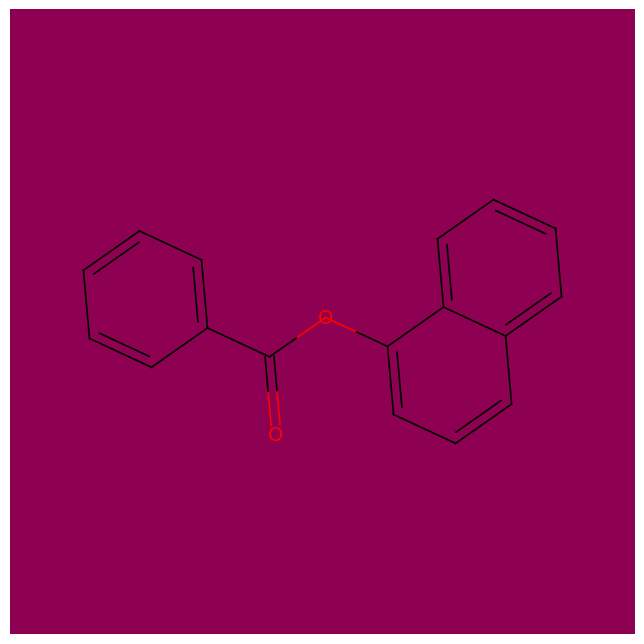

In [23]:
def myPredictionFuction(i_need_this):
    return 5

SimilarityMaps.GetSimilarityMapForModel(mols[5], SimilarityMaps.GetRDKFingerprint, myPredictionFuction)

In [24]:
from matchms import calculate_scores
from ms2deepscore import MS2DeepScore
from ms2deepscore.models import load_model

In [25]:
def notMyPredictionFunction(still_need_this):
    # Load pretrained model
    model = load_model("ms2deepscore_model.pt")

    similarity_measure = MS2DeepScore(model)
    # Calculate scores and get matchms.Scores object
    return calculate_scores(spectrums, spectrums, similarity_measure)

SimilarityMaps.GetSimilarityMapForModel(mols[5], SimilarityMaps.GetRDKFingerprint, notMyPredictionFunction)

The model version (2.0.0) does not match the version of MS2Deepscore (2.2.0), consider downloading a new model or changing the MS2Deepscore version


1267it [00:06, 190.99it/s]
1267it [00:06, 194.80it/s]


The model version (2.0.0) does not match the version of MS2Deepscore (2.2.0), consider downloading a new model or changing the MS2Deepscore version


1267it [00:06, 197.91it/s]
1267it [00:06, 197.29it/s]


TypeError: unsupported operand type(s) for -: 'Scores' and 'Scores'